In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.datasets import  fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchvision import transforms
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preparing the data

In [3]:
data = fetch_california_housing()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [4]:
X_train.shape

(16512, 8)

In [5]:
X_test.shape

(4128, 8)

In [6]:
y_train.shape

(16512,)

In [4]:
toTensorTransform = transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32))

In [8]:
class A:
    def __len__(self):
        return 3
    
    def __getitem__(self, index):
        return index

a = A()
# len(a)
a[6]

6

In [33]:
# Create a custom PyTorch dataset
class CaliforniaHousingDataset(Dataset):
    def __init__(self, features, targets, transform=None, target_transform=None):
        self.features = features
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y 

In [10]:
train_dataset = CaliforniaHousingDataset(X_train, y_train, transform=toTensorTransform, target_transform=toTensorTransform)
len(train_dataset)
train_dataset[5]

(tensor([ 1.4399, -0.6831,  0.3548, -0.2030,  1.1157,  0.0231,  0.8316, -1.1357]),
 tensor(2.6480))

In [13]:
torch.randn(10).view(-1, 1)

tensor([[ 1.6220],
        [-1.0400],
        [ 0.5438],
        [ 0.6756],
        [-0.4543],
        [ 1.7040],
        [ 0.6583],
        [ 0.5469],
        [-0.8871],
        [-0.4400]])

In [34]:
# Create instances of the custom dataset
train_dataset = CaliforniaHousingDataset(X_train, y_train, transform=toTensorTransform, 
                                         target_transform=transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)))
test_dataset = CaliforniaHousingDataset(X_test, y_test, transform=toTensorTransform, 
                                        target_transform=transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)))

# Create PyTorch data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [35]:
for data, target in train_loader:
    print(target.size())
    break

torch.Size([64, 1])


## Building your model

In [13]:
class MyLinear(nn.Module):

    def __init__(self, in_f, out_f, bias=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.bias = bias
        self.w = nn.parameter.Parameter(torch.empty(out_f, in_f))
        if bias:
            self.b = nn.parameter.Parameter(torch.empty(out_f)) 
        self.reset_params()   ### initialization paramters
    
    def reset_params(self):
        nn.init.kaiming_normal_(self.w, nonlinearity="relu")
        if self.bias:
            nn.init.constant_(self.b, 0)

    def forward(self, x):
        return F.linear(x, self.w, self.b)

In [28]:
def build_model(input_size, hidden_size, output_size):
    model = nn.Sequential(nn.Linear(input_size, hidden_size), 
                           nn.ReLU(),
                           nn.Linear(hidden_size, hidden_size), 
                           nn.ReLU(),  
                           nn.Linear(hidden_size, output_size))
    return model

# Train & Test

In [29]:
### custom LOSS function

class HuberLoss(nn.Module):   ### MSE <> MAE
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, predicted, target):
        residual = torch.abs(predicted - target)
        loss = torch.where(residual < self.delta, 0.5 * residual**2, self.delta * (residual - 0.5 * self.delta))
        return torch.mean(loss)

In [30]:
num_epochs = 30

model = build_model(8, 200, 1)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [43]:
class B:
    def salam_aleikom(self):
        print("salam aleikom")

    def __enter__(self):
        return self
    
    def __exit__(self, *args, **kwargs):
        print("maA salam")
    
with B() as b:
    b.salam_aleikom()
    print("payan context manager")

salam aleikom
payan context manager
maA salam


In [44]:
train_history = []
validation_history = []

for epoch in range(num_epochs):

    model.train()
    losses = []
    
    with tqdm(train_loader, leave=False) as bar:
        bar.set_description(f"[Epoch: {epoch + 1}/{num_epochs}]")
        
        for batch_idx, (data, target) in enumerate(bar):

            data = data.to(device)
            target = target.to(device)

            output = model(data)

            loss = criterion(output, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            bar.set_postfix(avg_epoch_loss=f"{sum(losses)/len(losses):.4f}")
    train_history.append(sum(losses)/len(losses))
        
    model.eval()
    running_testloss = 0.0

    with torch.no_grad():
        for i, (test_data, test_label) in enumerate(test_loader):
            test_output = model(test_data)
            vloss = criterion(test_output, test_label)
            running_testloss += vloss.item()
        avg_vloss = running_testloss / (i + 1)
        validation_history.append(avg_vloss)
        if epoch % 10 == 9:
            print(f'Epoch [{epoch + 1}/{num_epochs}]: loss train: {sum(losses)/len(losses):.3f}, validation: {avg_vloss:.3f}')

[Epoch: 1/30]:   1%|          | 3/258 [00:00<00:18, 14.08it/s, avg_epoch_loss=0.4652]

Epoch [10/30]: loss train: 0.296, validation: 0.300


Epoch [20/30]: loss train: 0.271, validation: 0.283


Epoch [30/30]: loss train: 0.255, validation: 0.273


In [45]:
with torch.no_grad():
    for data, target in test_loader:
        y_pred = model(data[:10])
        print("y_true", target[:10])
        print("y_pred", y_pred)
        break

y_true tensor([[0.4770],
        [0.4580],
        [5.0000],
        [2.1860],
        [2.7800],
        [1.5870],
        [1.9820],
        [1.5750],
        [3.4000],
        [4.4660]])
y_pred tensor([[0.4906],
        [1.0312],
        [5.0642],
        [2.5720],
        [2.7891],
        [1.6766],
        [2.4047],
        [1.6269],
        [2.5859],
        [4.7013]])


In [ ]:
k = 4
num_val_samples = len(train_dataset) // k
num_epochs = 100

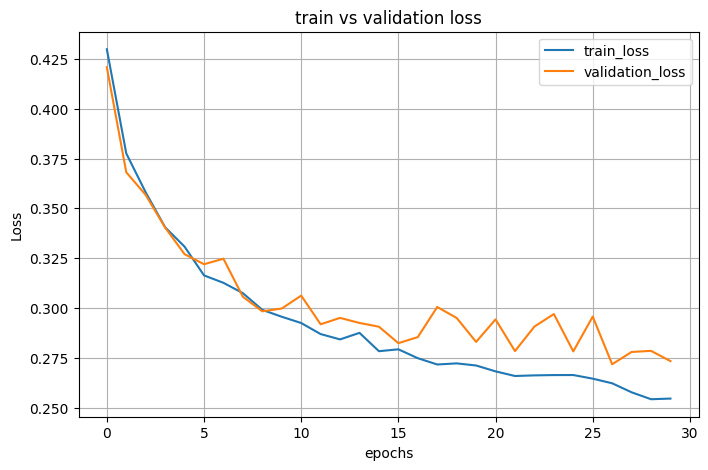

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_history, label="train_loss")
ax.plot(validation_history, label="validation_loss")
ax.set_title("train vs validation loss")
ax.set_ylabel('Loss')
ax.set_xlabel('epochs')
ax.grid()
ax.legend(loc='upper right')